In [1]:
import swat
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

from nyoka import skl_to_pmml

# Conexão com servidor

In [2]:
# Conexao com servidor
try:
    conn = swat.CAS( hostname="ip_do_servidor", port="5570",
                    username="usuario", password="senha",
                    protocol="cas", name="pythonSession")
except swat.SWATError as err:
    print(err)

In [3]:
tabela = conn.CASTable("TB_PY.sashdat").to_frame()

# Exploração dos Dados - Frequências

In [ ]:
for regiao,tam_reg in tabela.groupby('Cli_Regiao'):
    for reg, targ in tabela.groupby(['Cli_Regiao', 'TARGET']):
        regiao2, targets = reg
        if regiao == regiao2:
            if targets == 1:
                print("taxa de resposta (1s) em {} = {}".format(regiao, round((len(targ)/len(tam_reg)), 2)))

In [ ]:
# taxas de resposta dos status dos clientes
for status,tam_stat in tabela.groupby('Cli_Status'):
    for stat, targ in tabela.groupby(['Cli_Status', 'TARGET']):
        stat2, targets = stat
        if status == stat2:
            if targets == 1:
                print("taxa de resposta (1s) em {} = {}".format(status, round((len(targ)/len(tam_stat)), 2)))

##### Aparantemente platino e ouro podem ser unidos pois possuem taxa de resposta parecidas, embora tenham populações distintas

In [ ]:
# Agrupando platino e ouro
tabela["Cli_Status"] = np.where(tabela["Cli_Status"] == "Platino" , "Ouro", tabela["Cli_Status"] )

# taxas de resposta dos status dos clientes agora agrupados (ouro e platino)
for status,tam_stat in tabela.groupby('Cli_Status'):
    for stat, targ in tabela.groupby(['Cli_Status', 'TARGET']):
        stat2, targets = stat
        if status == stat2:
            if targets == 1:
                print("taxa de resposta (1s) em {} = {}".format(status, round((len(targ)/len(tam_stat)), 2)))

## Criação de Dummies

In [15]:
# para regiao
regiao = pd.Series(tabela["Cli_Regiao"])
reg_dum = pd.get_dummies(regiao)

# para status
status = pd.Series(tabela["Cli_Status"])
stat_dum = pd.get_dummies(status)

# merge final
tab_dum = pd.concat([tabela, reg_dum, stat_dum], axis = 1)

# remove variaveis anteriores
tab_dum.drop(["Cli_Regiao", "Cli_Status"], axis=1, inplace = True)

# Criação do Modelo

## Separação - treinamento/teste

In [16]:
train_test = tab_dum.drop(["TARGET"], axis=1)

# Separa em treinamento
X_train = train_test[train_test._PartInd_==1]
y_train = tab_dum[tab_dum._PartInd_==1]["TARGET"]

# Separa em teste
X_test = train_test[tab_dum._PartInd_==0]
y_test = tab_dum[tab_dum._PartInd_==0]["TARGET"]

# Retira variáveis não necessárias
X_test = X_test.drop(["_PartInd_","ID"], axis=1)
X_train = X_train.drop(["_PartInd_","ID"], axis=1)

## Treinamento

In [20]:
dt = Pipeline([
    ("dt", tree.DecisionTreeClassifier())
])

dt.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

## Scoragem

In [18]:
predicted = dt.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print( "Acurácia: ", accuracy)

Acurácia:  0.711864406779661


# Matriz de Confusão

In [8]:
cm = confusion_matrix(y_test, predicted)

tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()

print( "TN: ", tn)
print( "FP: ", fp)
print( "FN: ", fn)
print( "TP: ", tp)

TN:  4101
FP:  914
FN:  992
TP:  660


# Gráfico de Assessment - ROC

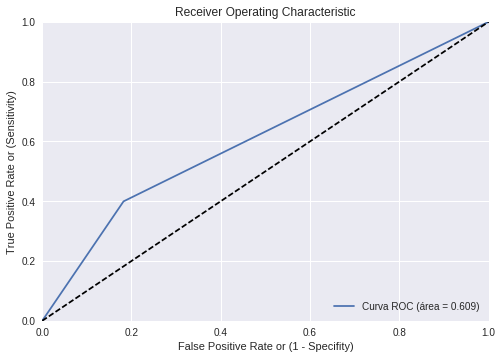

In [9]:
fpr, tpr, thresholds = roc_curve(tab_dum[tab_dum._PartInd_==0]["TARGET"], predicted)
roc_auc = roc_auc_score(tab_dum[tab_dum._PartInd_==0]["TARGET"], predicted)

plt.plot(fpr, tpr, label='Curva ROC (área = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Salva em PMML

In [23]:
skl_to_pmml(dt,list(X_train),"TARGET","pmml/dt2.pmml")

In [ ]:
conn.terminate()